# Import and Set Context

In [1]:
# # Check module locations if required
# import sys
# import pprint
# pprint.pprint(sys.path)

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import os
import io
from lxml import etree
from dateutil.relativedelta import *

import seaborn as sns; sns.set(style="darkgrid")
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import pickle
from tqdm.notebook import tqdm
import re

In [3]:
# Set display preference (Optional)
plt.rcParams["figure.figsize"] = (18,9)
plt.style.use('fivethirtyeight')

pd.options.display.max_rows = 20
pd.options.display.max_seq_items = 50
pd.set_option('display.max_colwidth', 200)

# Load Data
## FOMC Meeting
### Chairpersons

In [4]:
# FOMC Chairperson's list
chairpersons = pd.DataFrame(
    data=[["Volcker", "Paul", dt.datetime(1979,8,6), dt.datetime(1987,8,10)],
          ["Greenspan", "Alan", dt.datetime(1987,8,11), dt.datetime(2006,1,31)], 
          ["Bernanke", "Ben", dt.datetime(2006,2,1), dt.datetime(2014,1,31)], 
          ["Yellen", "Janet", dt.datetime(2014,2,3), dt.datetime(2018,2,3)],
          ["Powell", "Jerome", dt.datetime(2018,2,5), dt.datetime(2022,2,5)]],
    columns=["Surname", "FirstName", "FromDate", "ToDate"])
chairpersons

,Surname,FirstName,FromDate,ToDate
0,Volcker,Paul,1979-08-06,1987-08-10
1,Greenspan,Alan,1987-08-11,2006-01-31
2,Bernanke,Ben,2006-02-01,2014-01-31
3,Yellen,Janet,2014-02-03,2018-02-03
4,Powell,Jerome,2018-02-05,2022-02-05


In [5]:
def get_chairperson(x):
    '''
    Return a tuple of chairperson's Fullname for the given date x.
    '''
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strftime(x, '%Y-%m-%d')
        except:
            return None
    
    chairperson = chairpersons.loc[chairpersons['FromDate'] <= x].loc[x <= chairpersons['ToDate']]
    return list(chairperson.FirstName)[0] + " " + list(chairperson.Surname)[0]

### Load Calendar

In [47]:
file = open('../data/FOMC/fomc_calendar.pickle', 'rb')

fomc_calendar = pickle.load(file)
file.close()

print(fomc_calendar.shape)
fomc_calendar

(922, 4)


,date,unscheduled,forecast,confcall
0,1936-03-18,False,False,False
1,1936-03-19,False,False,False
2,1936-05-25,False,False,False
3,1936-11-19,False,False,False
4,1936-11-20,False,False,False
5,1937-01-26,False,False,False
6,1937-03-15,False,False,False
7,1937-04-04,False,False,False
8,1937-05-05,False,False,False
9,1937-06-09,False,False,False


In [48]:
# Take data between 1982/09/27 and 2020/6/5 because we have the target rate in this range.
# fomc_calendar = fomc_calendar.loc[fomc_calendar['date'] >= dt.datetime(1982, 9, 27)].loc[fomc_calendar['date'] <= dt.datetime(2020, 6, 5)]
fomc_calendar = fomc_calendar.loc[fomc_calendar['date'] >= dt.datetime(1982, 9, 27)]

# Use date as index
fomc_calendar.set_index('date', inplace=True)
fomc_calendar.head()

,unscheduled,forecast,confcall
date,,,
1982-10-05,False,False,False
1982-11-16,False,False,False
1982-12-21,False,False,False
1983-01-14,False,False,True
1983-01-21,False,False,True


### Add Chairperson to Calendar

In [49]:
fomc_calendar['ChairPerson'] = fomc_calendar.index.map(get_chairperson)
fomc_calendar

/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,unscheduled,forecast,confcall,ChairPerson
date,,,,
1982-10-05,False,False,False,Paul Volcker
1982-11-16,False,False,False,Paul Volcker
1982-12-21,False,False,False,Paul Volcker
1983-01-14,False,False,True,Paul Volcker
1983-01-21,False,False,True,Paul Volcker
1983-01-28,False,False,True,Paul Volcker
1983-02-09,False,False,False,Paul Volcker
1983-03-29,False,False,False,Paul Volcker
1983-04-29,False,False,True,Paul Volcker


## Load Market Data

### Target FED Rate

First tried to retrieve from contents, but it was not always accurate.
Thus, load historical FED Rate and match by the dates

Downloaded from FRB of New York (https://apps.newyorkfed.org/markets/autorates/fed%20funds)

In [9]:
# Load FED Target Rates
filename = '../data/MarketData/FEDRates/ffs-01172000-02092020.csv'

fedrates = pd.read_csv(filename, header=0, names=('Date', 'Vol', 'EFFR', '1st','25th' ,'75th' ,'99th' ,'Target' ,'Low' ,'High','Std.' ))
fedrates.index = pd.to_datetime(fedrates.Date, format="%d/%m/%Y")
fedrates.dropna(inplace=True, axis=0, subset=['Date', 'Target'])
fedrates.drop(columns=['Date', 'Vol', 'EFFR', '1st','25th' ,'75th' ,'99th','Low' ,'High','Std.'], inplace=True)

# Separate Range to Low and High
fedrates['Low'] = None
fedrates['High'] = None

for i in range(fedrates.shape[0]):
    target = fedrates['Target'][i]
    if '-' in target:
        fedrates['Low'][i] = re.findall(r'([0-9.]+)-', target)[0]
        fedrates['High'][i] = re.findall(r'-([0-9.]+)', target)[0]
    else:
        (fedrates['Low'][i], fedrates['High'][i]) = (target, target)

fedrates

,Target,Low,High
Date,,,
2020-02-06,1.50-1.75,1.50,1.75
2020-02-05,1.50-1.75,1.50,1.75
2020-02-04,1.50-1.75,1.50,1.75
2020-02-03,1.50-1.75,1.50,1.75
2020-01-31,1.50-1.75,1.50,1.75
2020-01-30,1.50-1.75,1.50,1.75
2020-01-29,1.50-1.75,1.50,1.75
2020-01-28,1.50-1.75,1.50,1.75
2020-01-27,1.50-1.75,1.50,1.75


In [10]:
fedrates.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4925 entries, 2020-02-06 to 2000-07-03
Data columns (total 3 columns):
Target    4925 non-null object
Low       4925 non-null object
High      4925 non-null object
dtypes: object(3)
memory usage: 313.9+ KB


/Users/yuki/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


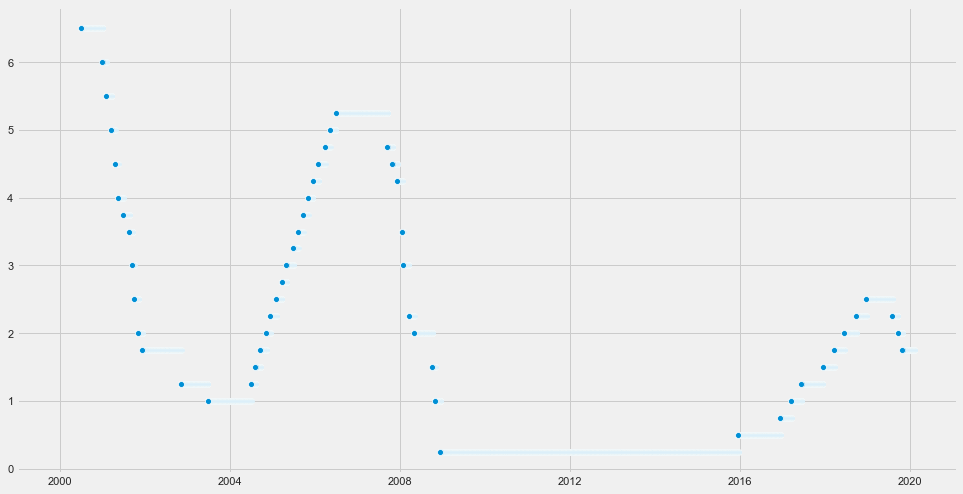

In [11]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot(data=(fedrates["High"].apply(lambda x: float(x))))

Looks good, but FRB of New York has historical data only from 2000.

So, download from FRB of St. Louis 
(https://fred.stlouisfed.org/searchresults?nasw=0&st=FED%20Rate&t=rate%3Bfederal%3Binterest%20rate&ob=sr&od=desc&types=gen).

Download the following three files in csv:

 * Federal Funds Target Range - Upper Limit
 * Federal Funds Target Range - Lower Limit
 * Federal Funds Target Rate (DISCONTINUED)

In [12]:
# FRB changed to range from 2008. So use lower side from 2008 as facing lower bound of zero.
filename_till08 = '../data/MarketData/FEDRates/DFEDTAR.csv'
filename_from08u = '../data/MarketData/FEDRates/DFEDTARU.csv'
filename_from08l = '../data/MarketData/FEDRates/DFEDTARL.csv'

fedtar = pd.read_csv(filename_till08, names=['Date', 'Rate'], header=0)
fedtaru = pd.read_csv(filename_from08u, names=['Date', 'Rate'], header=0)
fedtarl = pd.read_csv(filename_from08l, names=['Date', 'Rate'], header=0)
fedrate_df = pd.concat([fedtar, fedtarl], axis=0)
fedrate_df.index = pd.to_datetime(fedrate_df.Date, format="%Y-%m-%d")
fedrate_df.drop(columns=['Date'], inplace=True)
fedrate_df['Rate'] = fedrate_df['Rate'].map(lambda x: np.float(x))
# Add difference from previous value
fedrate_df['diff'] = fedrate_df['Rate'].diff()

fedrate_df

,Rate,diff
Date,,
1982-09-27,10.25,NaN
1982-09-28,10.25,0.00
1982-09-29,10.25,0.00
1982-09-30,10.25,0.00
1982-10-01,10.00,-0.25
1982-10-02,10.00,0.00
1982-10-03,10.00,0.00
1982-10-04,10.00,0.00
1982-10-05,10.00,0.00


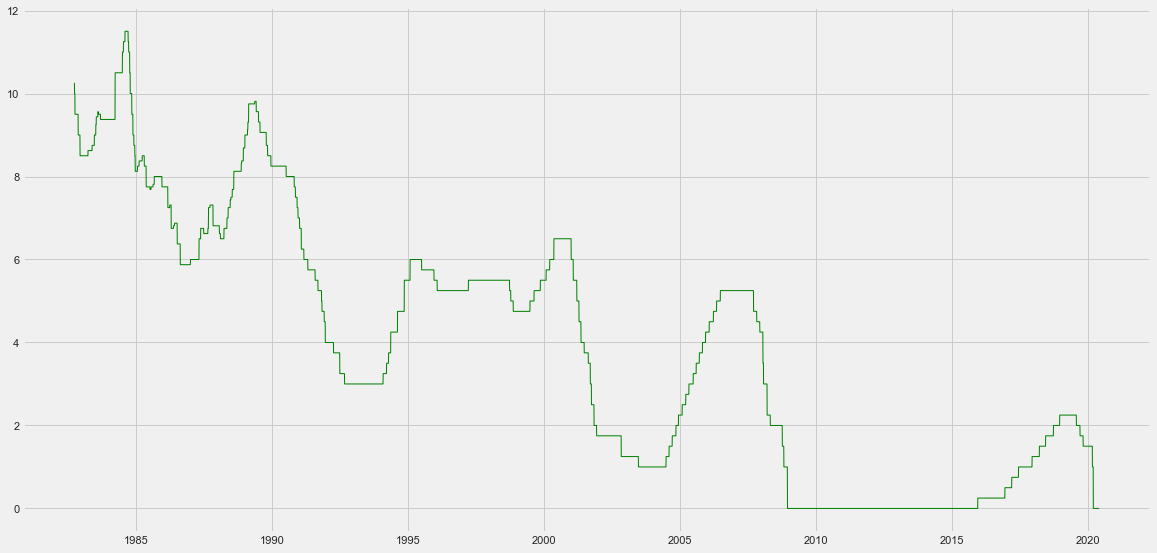

In [13]:
fig, ax = plt.subplots()
ax.plot(fedrate_df.index, fedrate_df['Rate'].values, 
         c = 'green',
         linewidth= 1.0)
ax.grid(True)
plt.show()

### Effective FED Rate

In [14]:
# Load FED Effective

filename = '../data/MarketData/FEDRates/DFF.csv'

dff = pd.read_csv(filename, header=0)
dff = dff.set_index(pd.to_datetime(dff['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])
# Add difference from previous value
dff['diff'] = dff['DFF'].diff()
dff

,DFF,diff
DATE,,
1954-07-01,1.13,NaN
1954-07-02,1.25,0.12
1954-07-03,1.25,0.00
1954-07-04,1.25,0.00
1954-07-05,0.88,-0.37
1954-07-06,0.25,-0.63
1954-07-07,1.00,0.75
1954-07-08,1.25,0.25
1954-07-09,1.25,0.00


(803, 2)


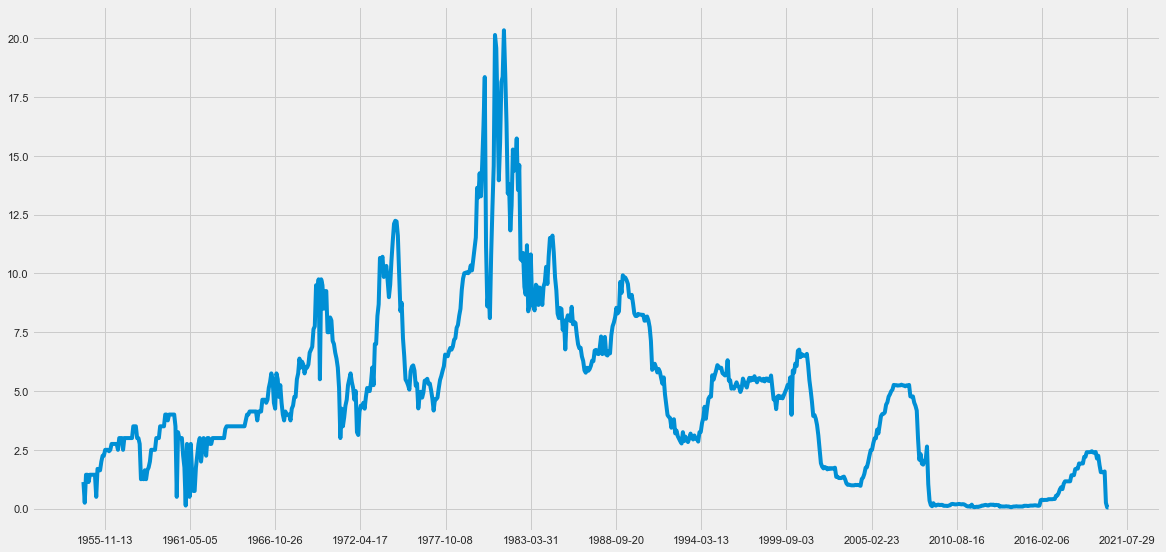

In [15]:
# Use every 30th row as it has too many data points
dff_30 = dff.iloc[::30, :]
print(dff_30.shape)

fig, ax = plt.subplots()
ax.plot(dff_30.index.values, dff_30['DFF'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

### GDP

Real GDP, Quarterly announced

In [16]:
# Load Real GDP
# Billions of Chained 2012 Dollars, Seasonally Adjusted Annual Rate

filename = '../data/MarketData/GDP/GDPC1.csv'

gdpc1 = pd.read_csv(filename, header=0)
gdpc1 = gdpc1.set_index(pd.to_datetime(gdpc1['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])
# Add difference from previous value
gdpc1['diff_prev'] = gdpc1['GDPC1'].diff() / gdpc1['GDPC1'].shift(1) * 100
gdpc1['diff_year'] = gdpc1['GDPC1'].diff(periods=4) / gdpc1['GDPC1'].shift(4) * 100
gdpc1

,GDPC1,diff_prev,diff_year
DATE,,,
1947-01-01,2033.061,NaN,NaN
1947-04-01,2027.639,-0.266691,NaN
1947-07-01,2023.452,-0.206496,NaN
1947-10-01,2055.103,1.564208,NaN
1948-01-01,2086.017,1.504256,2.604742
1948-04-01,2120.450,1.650658,4.577294
1948-07-01,2132.598,0.572897,5.394049
1948-10-01,2134.981,0.111742,3.886812
1949-01-01,2105.562,-1.377951,0.936953


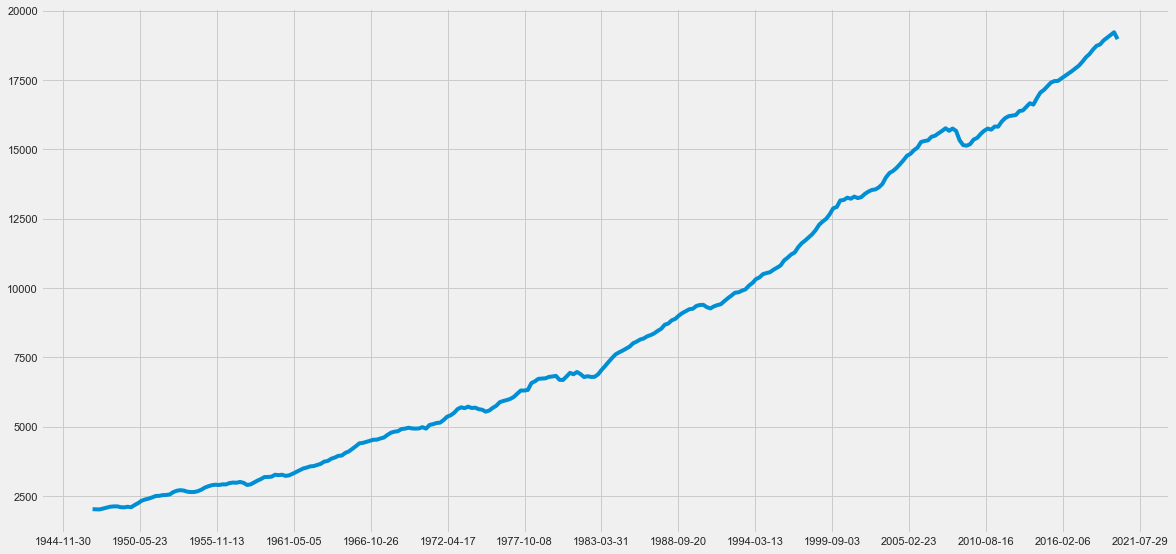

In [17]:
fig, ax = plt.subplots()
ax.plot(gdpc1.index.values, gdpc1['GDPC1'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

### Potential GDP

In [18]:
# Load Real Potential GDP
# Billions of Chained 2012 Dollars, Not Seasonally Adjusted

filename = '../data/MarketData/GDP/GDPPOT.csv'

gdppot = pd.read_csv(filename, header=0)
gdppot = gdppot.set_index(pd.to_datetime(gdppot['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])
# Add difference from previous value
gdppot['diff_prev'] = gdppot['GDPPOT'].diff() / gdppot['GDPPOT'].shift(1) * 100
gdppot['diff_year'] = gdppot['GDPPOT'].diff(periods=4) / gdppot['GDPPOT'].shift(4) * 100
gdppot

,GDPPOT,diff_prev,diff_year
DATE,,,
1949-01-01,2105.424751,NaN,NaN
1949-04-01,2133.335241,1.325647,NaN
1949-07-01,2162.374385,1.361209,NaN
1949-10-01,2190.094474,1.281928,NaN
1950-01-01,2219.369859,1.336718,5.411977
1950-04-01,2249.002234,1.335171,5.421885
1950-07-01,2278.748686,1.322651,5.381783
1950-10-01,2309.863306,1.365426,5.468661
1951-01-01,2341.614907,1.374610,5.508097


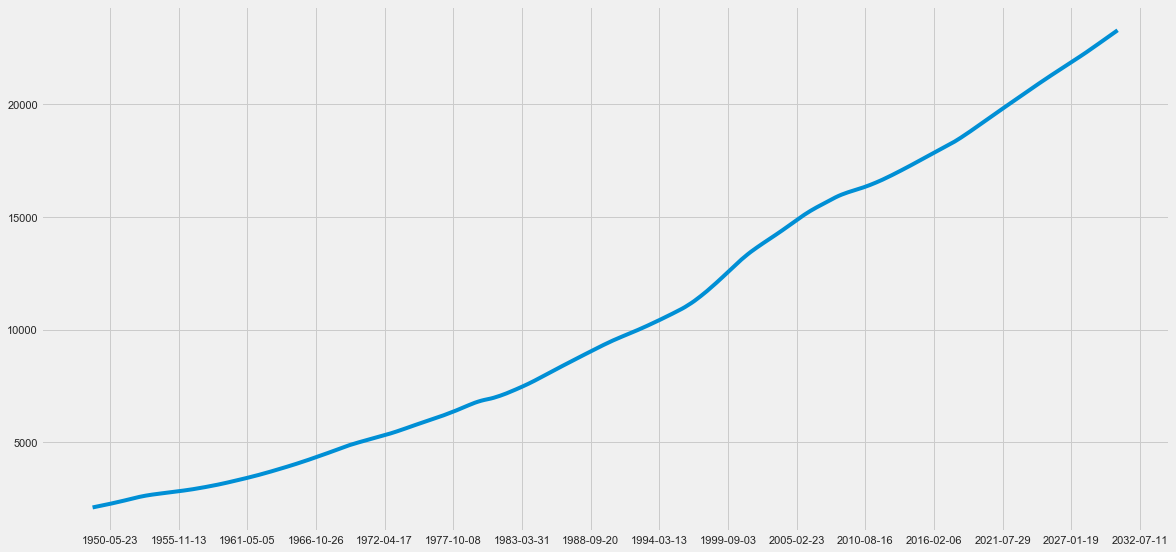

In [19]:
fig, ax = plt.subplots()
ax.plot(gdppot.index.values, gdppot['GDPPOT'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

### CPI

Use Core Consumer Price Index excluding Food and Energy as FRB takes this index as important indicator
It is announced monthly around 10th of each month for the previous month.

In [20]:
# Load Personal Consumption Expenditures Excluding Food and Energy (Chain-Type Price Index)
# Index 2012=100, Seasonally Adjusted

filename = '../data/MarketData/CPI/PCEPILFE.csv'

pcepilfe = pd.read_csv(filename, header=0)
pcepilfe = pcepilfe.set_index(pd.to_datetime(pcepilfe['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])
# Add difference from previous value
pcepilfe['diff_prev'] = pcepilfe['PCEPILFE'].diff() / pcepilfe['PCEPILFE'].shift(1) * 100
pcepilfe['diff_year'] = pcepilfe['PCEPILFE'].diff(periods=12) / pcepilfe['PCEPILFE'].shift(12) * 100
pcepilfe

,PCEPILFE,diff_prev,diff_year
DATE,,,
1959-01-01,16.727,NaN,NaN
1959-02-01,16.740,0.077719,NaN
1959-03-01,16.759,0.113501,NaN
1959-04-01,16.801,0.250612,NaN
1959-05-01,16.822,0.124993,NaN
1959-06-01,16.871,0.291285,NaN
1959-07-01,16.911,0.237093,NaN
1959-08-01,16.938,0.159659,NaN
1959-09-01,16.983,0.265675,NaN


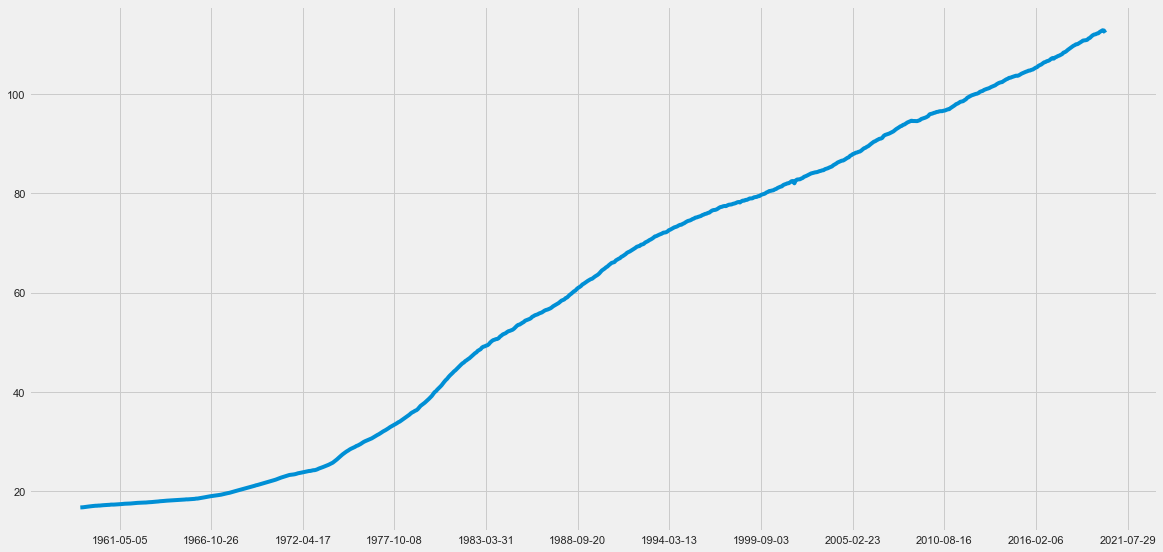

In [21]:
fig, ax = plt.subplots()
ax.plot(pcepilfe.index.values, pcepilfe['PCEPILFE'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

### Unemployment

Takes unemployment rate as important input for FRB's decision. Real Potential GDP is quarterly and usually two month after each quarter. On the other hand, unemployment is annnounced monthly, around a week after the end of each month and can be more real-time.

In [22]:
# Load Unemployment
# Percent, Seasonally Adjusted

filename = '../data/MarketData/Employment/UNRATE.csv'

unrate = pd.read_csv(filename, header=0)
unrate = unrate.set_index(pd.to_datetime(unrate['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])
# Add difference from previous value
unrate['diff_prev'] = unrate['UNRATE'].diff()
unrate['diff_year'] = unrate['UNRATE'].diff(periods=12)
unrate

,UNRATE,diff_prev,diff_year
DATE,,,
1948-01-01,3.4,NaN,NaN
1948-02-01,3.8,0.4,NaN
1948-03-01,4.0,0.2,NaN
1948-04-01,3.9,-0.1,NaN
1948-05-01,3.5,-0.4,NaN
1948-06-01,3.6,0.1,NaN
1948-07-01,3.6,0.0,NaN
1948-08-01,3.9,0.3,NaN
1948-09-01,3.8,-0.1,NaN


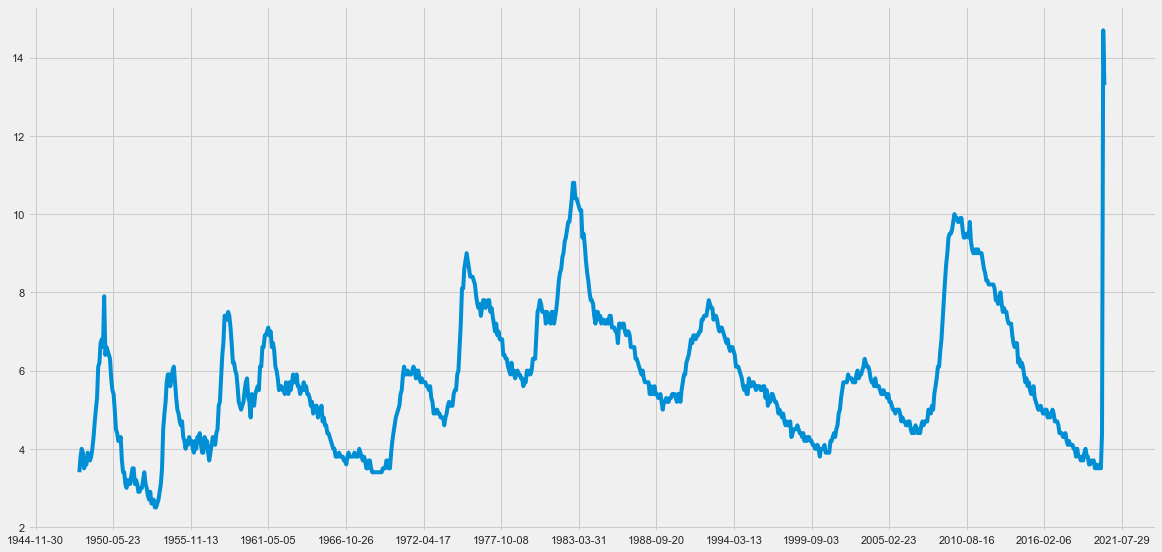

In [23]:
fig, ax = plt.subplots()
ax.plot(unrate.index.values, unrate['UNRATE'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

### Employment

In [24]:
# Load Unemployment
# Percent, Seasonally Adjusted

filename = '../data/MarketData/Employment/PAYEMS.csv'

payems = pd.read_csv(filename, header=0)
payems = payems.set_index(pd.to_datetime(payems['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])
# Add difference from previous value
payems['diff_prev'] = payems['PAYEMS'].diff()
payems['diff_year'] = payems['PAYEMS'].diff(periods=12)
payems

,PAYEMS,diff_prev,diff_year
DATE,,,
1939-01-01,29923,NaN,NaN
1939-02-01,30100,177.0,NaN
1939-03-01,30280,180.0,NaN
1939-04-01,30094,-186.0,NaN
1939-05-01,30299,205.0,NaN
1939-06-01,30502,203.0,NaN
1939-07-01,30419,-83.0,NaN
1939-08-01,30663,244.0,NaN
1939-09-01,31031,368.0,NaN


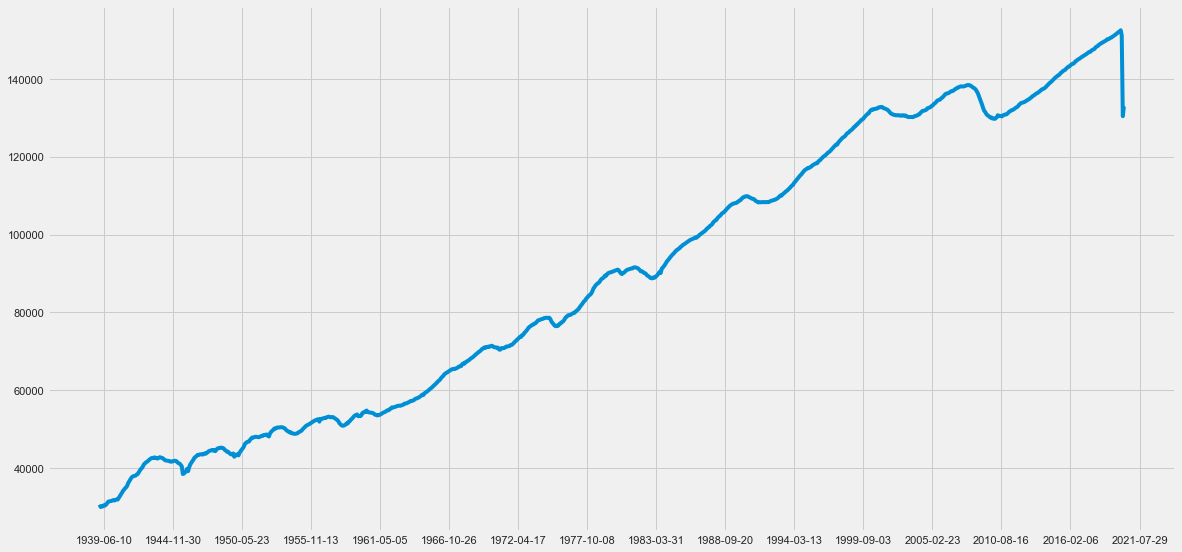

In [25]:
fig, ax = plt.subplots()
ax.plot(payems.index.values, payems['PAYEMS'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

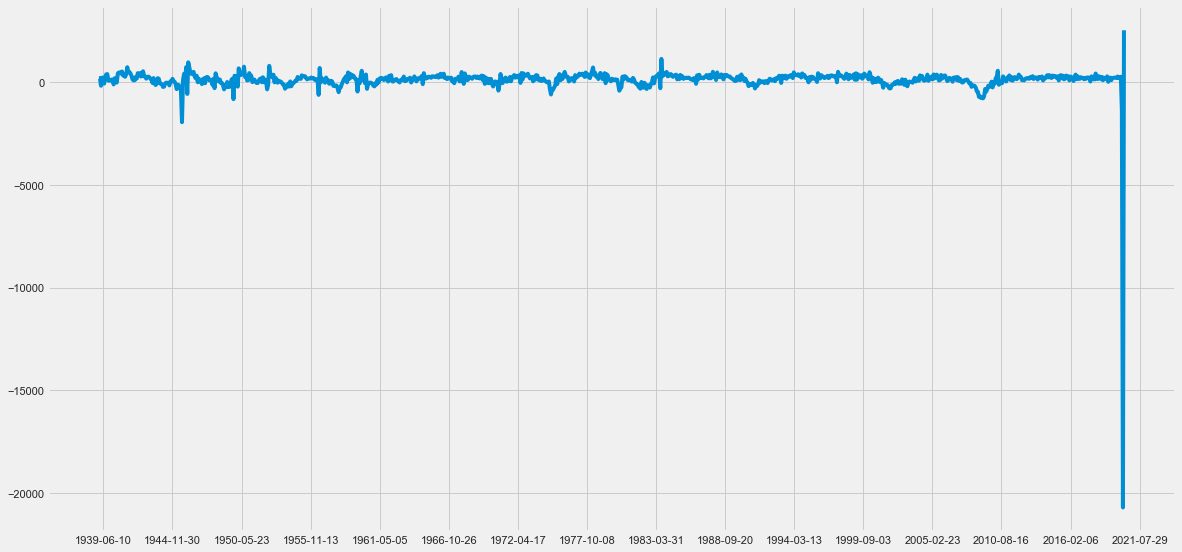

In [26]:
fig, ax = plt.subplots()
ax.plot(payems.index.values, payems['diff_prev'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

### ISM Purchasing Managers Index / Non-manufacturing Index

Another important indicator of the economy, also announced monthly right after the end of each month.

In [27]:
# Load ISM PMI
filename = '../data/MarketData/ISM/ISM-MAN_PMI.csv'

ism_pmi = pd.read_csv(filename, header=0)
ism_pmi = ism_pmi.sort_values(by=['Date'], ascending=True)
ism_pmi = ism_pmi.set_index(pd.to_datetime(ism_pmi['Date'], format="%Y-%m-%d")).drop(columns=['Date'])
# Add difference from previous value
ism_pmi['diff_prev'] = ism_pmi['PMI'].diff()
ism_pmi['diff_year'] = ism_pmi['PMI'].diff(periods=12)
ism_pmi

,PMI,diff_prev,diff_year
Date,,,
1948-01-01,51.7,NaN,NaN
1948-02-01,50.2,-1.5,NaN
1948-03-01,43.3,-6.9,NaN
1948-04-01,45.4,2.1,NaN
1948-05-01,49.5,4.1,NaN
1948-06-01,53.0,3.5,NaN
1948-07-01,48.4,-4.6,NaN
1948-08-01,45.1,-3.3,NaN
1948-09-01,42.1,-3.0,NaN


In [28]:
# Load ISM NMI
filename = '../data/MarketData/ISM/ISM-NONMAN_NMI.csv'

ism_nmi = pd.read_csv(filename, header=0)
ism_nmi = ism_nmi.sort_values(by=['Date'], ascending=True)
ism_nmi.columns = ['Date', 'NMI']
ism_nmi = ism_nmi.set_index(pd.to_datetime(ism_nmi['Date'], format="%Y-%m-%d")).drop(columns=['Date'])
# Add difference from previous value
ism_nmi['diff_prev'] = ism_nmi['NMI'].diff()
ism_nmi['diff_year'] = ism_nmi['NMI'].diff(periods=12)
ism_nmi

,NMI,diff_prev,diff_year
Date,,,
2008-01-01,45.0,NaN,NaN
2008-02-01,49.9,4.9,NaN
2008-03-01,49.4,-0.5,NaN
2008-04-01,51.8,2.4,NaN
2008-05-01,51.4,-0.4,NaN
2008-06-01,48.3,-3.1,NaN
2008-07-01,50.0,1.7,NaN
2008-08-01,50.6,0.6,NaN
2008-09-01,49.4,-1.2,NaN


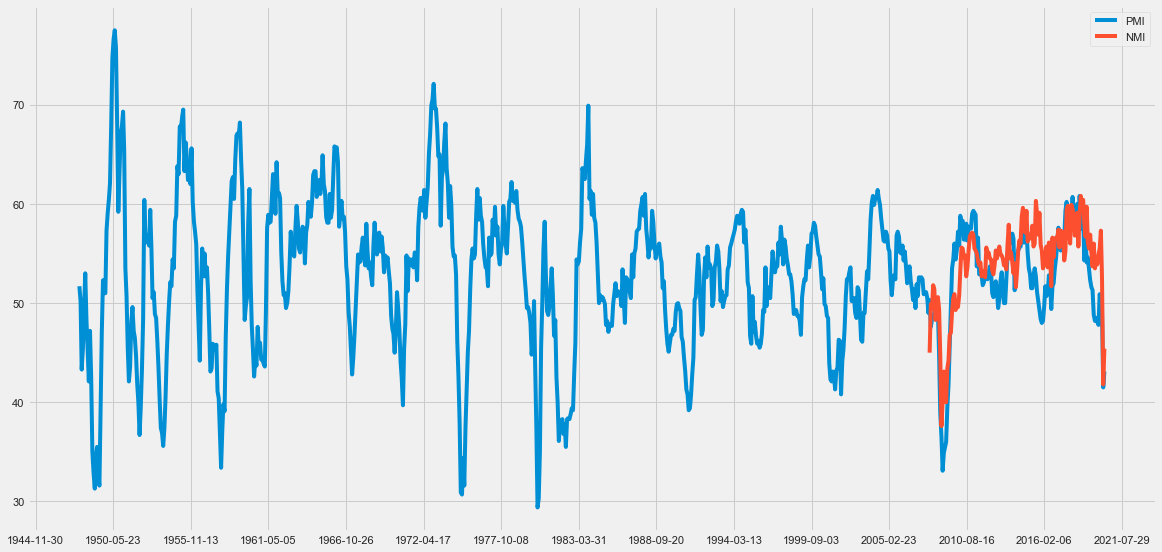

In [29]:
fig, ax = plt.subplots()
ax.plot(ism_pmi.index.values, ism_pmi['PMI'].values)
ax.plot(ism_nmi.index.values, ism_nmi['NMI'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
ax.legend(['PMI', 'NMI'])
plt.show()


Non-manufacturing index (NMI) is available only post 2008. <br /> It cannot cover a lot percentage of the target period, decided not to use it.

### Treasury Yield

In [30]:
# Load US Treasury Yield
# https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yieldAll
xml_path = '../data/MarketData/Treasury/DailyTreasuryYieldCurveRateData.xml'
xml_data = etree.parse(xml_path) #create an ElementTree object

namespaces = {"base": "http://data.treasury.gov/Feed.svc/",
              "d": "http://schemas.microsoft.com/ado/2007/08/dataservices",
              "m": "http://schemas.microsoft.com/ado/2007/08/dataservices/metadata",
              "x": "http://www.w3.org/2005/Atom"}

df_cols = ["date", "1month", "2month", "3montn", "6montn", "1year", "2year", "3year", "5year", "7year", "10year", "20year", "30year"]
rows = []

contents = xml_data.xpath('/x:feed/x:entry/x:content', namespaces=namespaces)
for content in contents:
    s_date = content.xpath('./m:properties/d:NEW_DATE', namespaces=namespaces)[0].text[:10]
    s_1month = content.xpath('./m:properties/d:BC_1MONTH', namespaces=namespaces)[0].text
    s_2month = content.xpath('./m:properties/d:BC_2MONTH', namespaces=namespaces)[0].text
    s_3month = content.xpath('./m:properties/d:BC_3MONTH', namespaces=namespaces)[0].text
    s_6month = content.xpath('./m:properties/d:BC_6MONTH', namespaces=namespaces)[0].text
    s_1year = content.xpath('./m:properties/d:BC_1YEAR', namespaces=namespaces)[0].text
    s_2year = content.xpath('./m:properties/d:BC_2YEAR', namespaces=namespaces)[0].text
    s_3year = content.xpath('./m:properties/d:BC_3YEAR', namespaces=namespaces)[0].text
    s_5year = content.xpath('./m:properties/d:BC_5YEAR', namespaces=namespaces)[0].text
    s_7year = content.xpath('./m:properties/d:BC_7YEAR', namespaces=namespaces)[0].text
    s_10year = content.xpath('./m:properties/d:BC_10YEAR', namespaces=namespaces)[0].text
    s_20year = content.xpath('./m:properties/d:BC_20YEAR', namespaces=namespaces)[0].text
    s_30year = content.xpath('./m:properties/d:BC_30YEAR', namespaces=namespaces)[0].text
    
    rows.append({"date": dt.datetime.strptime(s_date, '%Y-%m-%d'),
                 "1month": s_1month,
                 "2month": s_2month, 
                 "3montn": s_3month, 
                 "6montn": s_6month, 
                 "1year": s_1year, 
                 "2year": s_2year, 
                 "3year": s_3year, 
                 "5year": s_5year, 
                 "7year": s_7year, 
                 "10year": s_10year, 
                 "20year": s_20year, 
                 "30year": s_30year})

treasury = pd.DataFrame(rows, columns = df_cols).set_index('date').sort_index(ascending=True).astype(float)
treasury

,1month,2month,3montn,6montn,1year,2year,3year,5year,7year,10year,20year,30year
date,,,,,,,,,,,,
1990-01-02,NaN,NaN,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,NaN,8.00
1990-01-03,NaN,NaN,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,NaN,8.04
1990-01-04,NaN,NaN,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,NaN,8.04
1990-01-05,NaN,NaN,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,NaN,8.06
1990-01-08,NaN,NaN,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,NaN,8.09
1990-01-09,NaN,NaN,7.80,7.82,7.78,7.91,7.94,7.92,8.05,8.02,NaN,8.10
1990-01-10,NaN,NaN,7.75,7.78,7.77,7.91,7.95,7.92,8.00,8.03,NaN,8.11
1990-01-11,NaN,NaN,7.80,7.80,7.77,7.91,7.95,7.94,8.01,8.04,NaN,8.11
1990-01-12,NaN,NaN,7.74,7.81,7.76,7.93,7.98,7.99,8.07,8.10,NaN,8.17


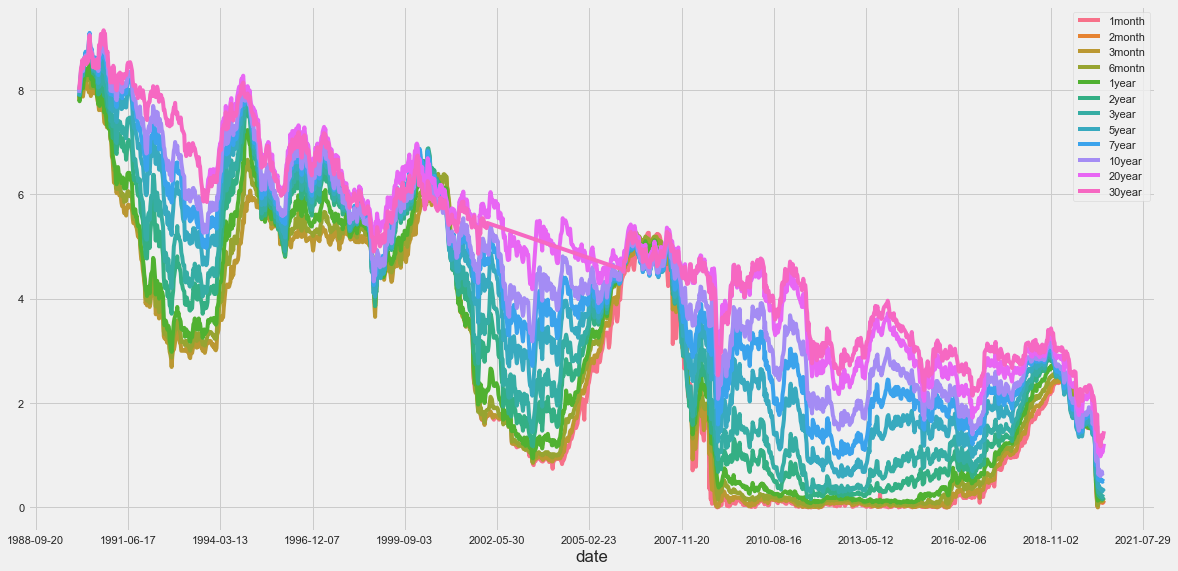

In [31]:
# Use every 5th row as it has too many data points
treasury_5 = treasury.iloc[::5, :]

fig, ax = plt.subplots()
ax = sns.lineplot(data = treasury_5, dashes=False)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1000))
plt.show()

# Process the data

## Add Rate and Decisions

In [52]:
# The target range was changed a couple of days after the announcement in the past,
#  while it is immediately put in effect on the day recently.
# Use the target rate three days after the meeting as target announced,
#  compare it with previous day's rate to check if rate has been changed.
#   -1: Rate lower
#    0: No change
#   +1: Rate hike

rate_list = []
decision_list = []


for i in tqdm(range(len(fomc_calendar))):
    not_found = True
    for j in range(len(fedrate_df)):
        if fomc_calendar.index[i] == fedrate_df.index[j]:
            not_found = False
            rate_list.append(float(fedrate_df['Rate'].iloc[j+3]))
            if fedrate_df['Rate'].iloc[j-1] == fedrate_df['Rate'].iloc[j+3]:
                decision_list.append(0)
            elif fedrate_df['Rate'].iloc[j-1] < fedrate_df['Rate'].iloc[j+3]:
                decision_list.append(1)
            elif fedrate_df['Rate'].iloc[j-1] > fedrate_df['Rate'].iloc[j+3]:
                decision_list.append(-1)
    if not_found:
        rate_list.append(np.nan)
        decision_list.append(np.nan)

fomc_calendar.loc[:,'Rate'] = rate_list
fomc_calendar.loc[:,'RateDecision'] = decision_list
fomc_calendar.dropna(subset=['Rate'], inplace=True)

fomc_calendar

,unscheduled,forecast,confcall,ChairPerson,Rate,RateDecision
date,,,,,,
1982-10-05,False,False,False,Paul Volcker,9.500,-1.0
1982-11-16,False,False,False,Paul Volcker,9.000,-1.0
1982-12-21,False,False,False,Paul Volcker,8.500,0.0
1983-01-14,False,False,True,Paul Volcker,8.500,0.0
1983-01-21,False,False,True,Paul Volcker,8.500,0.0
1983-01-28,False,False,True,Paul Volcker,8.500,0.0
1983-02-09,False,False,False,Paul Volcker,8.500,0.0
1983-03-29,False,False,False,Paul Volcker,8.625,1.0
1983-04-29,False,False,True,Paul Volcker,8.625,0.0


In [34]:
# # Calculate the next business day (not used for now)
# from pandas.tseries.holiday import USFederalHolidayCalendar
# cal = USFederalHolidayCalendar()
# holidays = cal.holidays(start='1982-01-01', end='2020-12-31').strftime('%Y-%m-%d')
# bdd = np.busdaycalendar(weekmask='1111100', holidays=holidays)

# np.busday_offset('2011-01-01', np.arange(366), roll='forward', busdaycal=bdd)
# np.busday_offset('1982-10-06', 0, roll='forward', busdaycal=bdd)

Though this is not perfect as Target Rate was sometimes changed between FOMC meetings, enough to analyze the impact of FOMC Meetings.

## Create Train Data Set

In [32]:
# Create one DataFrame as train_data, starting from fomc_calendar
train_data = fomc_calendar.copy()

## Add Quantitative Easing as a Lower event
Between 2008 and 2016 saw zero interest rate. Main monetary measure shifted to quantity from rate. Thus, add "lower" events when those QE was announced.

In [50]:
# Add 2008-11-25 to fomc_calendar when QE was first announced but not in FOMC Calendar
if fomc_calendar.loc[fomc_calendar.index.values == dt.datetime.strptime('2008-11-25', '%Y-%m-%d')].shape[0] == 0:
    fomc_calendar = fomc_calendar.append(pd.Series([True, False, False, 'Ben Bernanke'], index=['unscheduled', 'forecast', 'confcall', 'ChairPerson'], name=dt.datetime.strptime('2008-11-25', '%Y-%m-%d')))

# Mark RateDecision = -1 (lower) even when rate is not changed but additional quantitative measures were announced
if train_data.loc[train_data.index.values == dt.datetime.strptime('2008-11-25', '%Y-%m-%d')].shape[0] == 0:
    train_data = train_data.append(pd.Series([True, False, False, -1, 0.25], index=['unscheduled', 'forecast', 'confcall', 'RateDecision', 'Rate'], name=dt.datetime.strptime('2008-11-25', '%Y-%m-%d'))) # QE1 Announced

# Make the other timings of QE Expansion lowering events
train_data.loc[train_data.index == dt.datetime(2009,3,18), 'RateDecision'] = -1 # QE1 Expanded
train_data.loc[train_data.index == dt.datetime(2010,11,3), 'RateDecision'] = -1 # QE2 Announced
train_data.loc[train_data.index == dt.datetime(2011,9,21), 'RateDecision'] = -1 # Operation Twist Announced
train_data.loc[train_data.index == dt.datetime(2012,6,20), 'RateDecision'] = -1 # Operation Twist Extended
train_data.loc[train_data.index == dt.datetime(2012,9,13), 'RateDecision'] = -1 # QE3 Announced
train_data.loc[train_data.index == dt.datetime(2012,12,12), 'RateDecision'] = -1 # QE3 Expanded

# It was announced QE ends - regard this as hike
train_data.loc[train_data.index == dt.datetime(2013,6,19), 'RateDecision'] = 1 # Tapering Announced
#fomc_calendar.loc['2013-12-18', 'RateDecision'] = 1 # Tapering Begins
#fomc_calendar.loc['2014-10-29', 'RateDecision'] = 1 # QE3 Terminated
#fomc_calendar.loc['2017-06-14', 'RateDecision'] = 1 # Signaled Balance Sheet Normalization
#fomc_calendar.loc['2017-09-20', 'RateDecision'] = 1 # Stated Balance Sheet Normalization Begins in Oct
train_data.sort_index(ascending=True, inplace=True)
train_data

,unscheduled,forecast,confcall,ChairPerson,Rate,RateDecision,Lower,Hold,Raise,GDP_date,...,Unemp_diff_prev,Unemp_diff_year,Employ_date,Employ_value,Employ_diff_prev,Employ_diff_year,PMI_date,PMI_value,PMI_diff_prev,PMI_diff_year
date,,,,,,,,,,,,,,,,,,,,,
1982-10-05,False,False,False,Paul Volcker,9.500,-1.0,1.0,0.0,0.0,1982-04-01 00:00:00,...,0.3,2.5,1982-09-01 00:00:00,89183.0,-180.0,-2294.0,1982-09-01 00:00:00,38.8,0.5,-3.7
1982-11-16,False,False,False,Paul Volcker,9.000,-1.0,1.0,0.0,0.0,1982-07-01 00:00:00,...,0.3,2.5,1982-10-01 00:00:00,88907.0,-276.0,-2473.0,1982-10-01 00:00:00,39.4,0.6,-0.6
1982-12-21,False,False,False,Paul Volcker,8.500,0.0,0.0,1.0,0.0,1982-07-01 00:00:00,...,0.4,2.5,1982-11-01 00:00:00,88786.0,-121.0,-2385.0,1982-11-01 00:00:00,39.2,-0.2,3.1
1983-01-14,False,False,True,Paul Volcker,8.500,0.0,0.0,1.0,0.0,1982-07-01 00:00:00,...,0.0,2.3,1982-12-01 00:00:00,88771.0,-15.0,-2124.0,1982-12-01 00:00:00,42.8,3.6,5.0
1983-01-21,False,False,True,Paul Volcker,8.500,0.0,0.0,1.0,0.0,1982-07-01 00:00:00,...,0.0,2.3,1982-12-01 00:00:00,88771.0,-15.0,-2124.0,1982-12-01 00:00:00,42.8,3.6,5.0
1983-01-28,False,False,True,Paul Volcker,8.500,0.0,0.0,1.0,0.0,1982-07-01 00:00:00,...,0.0,2.3,1982-12-01 00:00:00,88771.0,-15.0,-2124.0,1982-12-01 00:00:00,42.8,3.6,5.0
1983-02-09,False,False,False,Paul Volcker,8.500,0.0,0.0,1.0,0.0,1982-10-01 00:00:00,...,-0.4,1.8,1983-01-01 00:00:00,88990.0,219.0,-1575.0,1983-01-01 00:00:00,46.0,3.2,7.8
1983-03-29,False,False,False,Paul Volcker,8.625,1.0,0.0,0.0,1.0,1982-10-01 00:00:00,...,0.0,1.5,1983-02-01 00:00:00,88917.0,-73.0,-1646.0,1983-02-01 00:00:00,54.4,8.4,16.1
1983-04-29,False,False,True,Paul Volcker,8.625,0.0,0.0,1.0,0.0,1982-10-01 00:00:00,...,-0.1,1.3,1983-03-01 00:00:00,89090.0,173.0,-1344.0,1983-03-01 00:00:00,53.9,-0.5,17.1


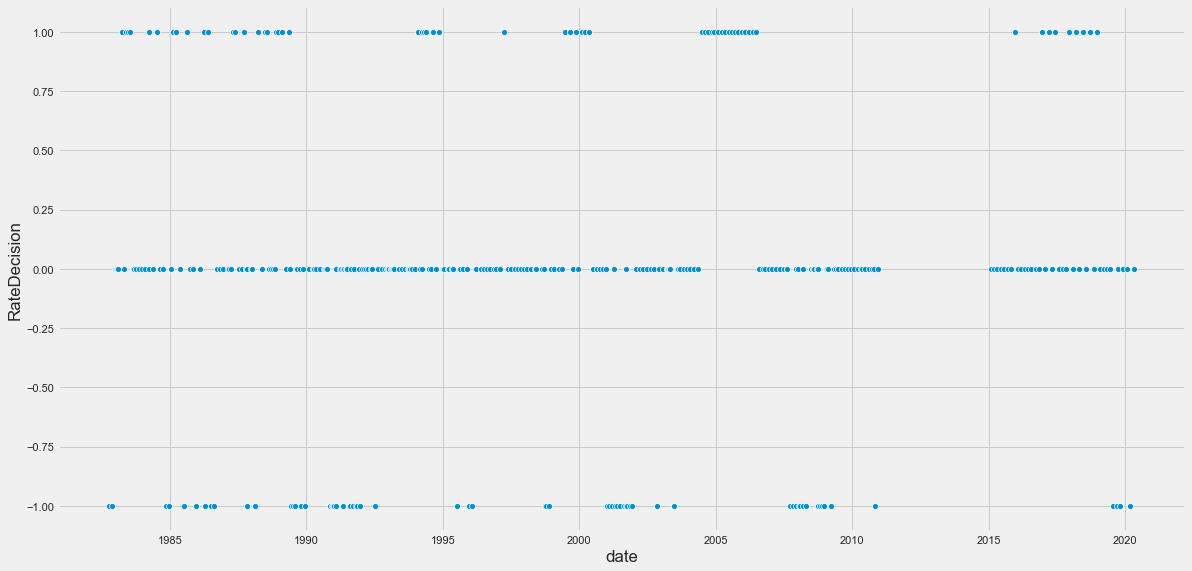

In [36]:
sns.scatterplot(x=train_data.index, y=train_data['RateDecision'].apply(lambda x: float(x)))

## One-hot encoding of the rate decision

In [37]:
train_data['Lower'] = train_data['RateDecision'].apply(lambda x: 1 if x == -1 else 0)
train_data['Hold'] = train_data['RateDecision'].apply(lambda x: 1 if x == 0 else 0)
train_data['Raise'] = train_data['RateDecision'].apply(lambda x: 1 if x == 1 else 0)
train_data

,unscheduled,forecast,confcall,ChairPerson,Rate,RateDecision,Lower,Hold,Raise
date,,,,,,,,,
1982-10-05,False,False,False,Paul Volcker,9.500,-1.0,1,0,0
1982-11-16,False,False,False,Paul Volcker,9.000,-1.0,1,0,0
1982-12-21,False,False,False,Paul Volcker,8.500,0.0,0,1,0
1983-01-14,False,False,True,Paul Volcker,8.500,0.0,0,1,0
1983-01-21,False,False,True,Paul Volcker,8.500,0.0,0,1,0
1983-01-28,False,False,True,Paul Volcker,8.500,0.0,0,1,0
1983-02-09,False,False,False,Paul Volcker,8.500,0.0,0,1,0
1983-03-29,False,False,False,Paul Volcker,8.625,1.0,0,0,1
1983-04-29,False,False,True,Paul Volcker,8.625,0.0,0,1,0


In [38]:
train_data.shape

(359, 9)

## Add major economic indices

In [39]:
def get_available_latest(train_df, index_df, value_col, diff_prev_col, diff_year_col, date_offset):
    '''
    Returns the latest available ecoonmic index for each row of train_df
    INPUTS:
        train_df: Index must be in datetime format
        idex_df: Index must be in datetime format
        value_col: The column name of the value in index_df
        diff_prev_col: The column name of the difference from previous period in index_df
        diff_year_col: The column name of the difference from the same priod in previous year in index_df
        date_offset: Use relativedelta for the offset when the index is published
    OUTPUTS:
        date_list: List of date matched with train_df.index
        value_list: List of values for the date_list
        diff_list: List of diff values for the date_list
    '''
    
    date_list, value_list, diff_prev_list, diff_year_list = [], [], [], []
    
    for i, row_data in tqdm(train_df.iterrows(), total=train_df.shape[0]):
        #print(row_data.name)
        for j, row_index in index_df.sort_index(ascending=False).iterrows():
            if row_data.name > row_index.name + date_offset:
                #print("   matched: ", row_index.name)
                date_list.append(row_index.name)
                value_list.append(row_index[value_col])
                diff_prev_list.append(row_index[diff_prev_col])
                diff_year_list.append(row_index[diff_year_col])
                break
    if train_df.shape[0] != len(date_list):
        print("train_df has {} rows but returned {} rows from index_df!".format(train_df.shape[0], len(date_list)))
    
    return date_list, value_list, diff_prev_list, diff_year_list

In [40]:
# GDP is announced quarterly, the end of following month (preliminary)
print("Processing GDP...")
train_data['GDP_date'], train_data['GDP_value'], train_data['GDP_diff_prev'], train_data['GDP_diff_year'] \
= get_available_latest(train_data, gdpc1, 'GDPC1', 'diff_prev', 'diff_year', relativedelta(months=+4, days=-2))

print("Processing Potential GDP...")
train_data['GDPPOT_date'], train_data['GDPPOT_value'], train_data['GDPPOT_diff_prev'], train_data['GDPPOT_diff_year'] \
= get_available_latest(train_data, gdppot, 'GDPPOT', 'diff_prev', 'diff_year', relativedelta(months=+4, days=-2))

# CPI is announced monthly, around 10th of the end of following month
print("Processing CPI...")
train_data['CPI_date'], train_data['CPI_value'], train_data['CPI_diff_prev'], train_data['CPI_diff_year'] \
= get_available_latest(train_data, pcepilfe, 'PCEPILFE', 'diff_prev', 'diff_year', relativedelta(months=+1, days=+9))

# Employment statistics is announced monthly, around 3rd of the end of following month
print("Processing Unemployemnt...")
train_data['Unemp_date'], train_data['Unemp_value'], train_data['Unemp_diff_prev'], train_data['Unemp_diff_year'] \
= get_available_latest(train_data, unrate, 'UNRATE', 'diff_prev', 'diff_year', relativedelta(months=+1, days=+2))

# Employment statistics is announced monthly, around 3rd of the end of following month
print("Processing Employment...")
train_data['Employ_date'], train_data['Employ_value'], train_data['Employ_diff_prev'], train_data['Employ_diff_year'] \
= get_available_latest(train_data, payems, 'PAYEMS', 'diff_prev', 'diff_year', relativedelta(months=+1, days=+2))

# ISM PMI is areannounced monthly, around 1st of the end of following month
print("Processing ISM PMI...")
train_data['PMI_date'], train_data['PMI_value'], train_data['PMI_diff_prev'], train_data['PMI_diff_year'] \
= get_available_latest(train_data, ism_pmi, 'PMI', 'diff_prev', 'diff_year', relativedelta(months=+1, days=+2))


Processing GDP...



Processing Potential GDP...



Processing CPI...



Processing Unemployemnt...



Processing Employment...



Processing ISM PMI...


In [41]:
train_data

,unscheduled,forecast,confcall,ChairPerson,Rate,RateDecision,Lower,Hold,Raise,GDP_date,...,Unemp_diff_prev,Unemp_diff_year,Employ_date,Employ_value,Employ_diff_prev,Employ_diff_year,PMI_date,PMI_value,PMI_diff_prev,PMI_diff_year
date,,,,,,,,,,,,,,,,,,,,,
1982-10-05,False,False,False,Paul Volcker,9.500,-1.0,1,0,0,1982-04-01,...,0.3,2.5,1982-09-01,89183.0,-180.0,-2294.0,1982-09-01,38.8,0.5,-3.7
1982-11-16,False,False,False,Paul Volcker,9.000,-1.0,1,0,0,1982-07-01,...,0.3,2.5,1982-10-01,88907.0,-276.0,-2473.0,1982-10-01,39.4,0.6,-0.6
1982-12-21,False,False,False,Paul Volcker,8.500,0.0,0,1,0,1982-07-01,...,0.4,2.5,1982-11-01,88786.0,-121.0,-2385.0,1982-11-01,39.2,-0.2,3.1
1983-01-14,False,False,True,Paul Volcker,8.500,0.0,0,1,0,1982-07-01,...,0.0,2.3,1982-12-01,88771.0,-15.0,-2124.0,1982-12-01,42.8,3.6,5.0
1983-01-21,False,False,True,Paul Volcker,8.500,0.0,0,1,0,1982-07-01,...,0.0,2.3,1982-12-01,88771.0,-15.0,-2124.0,1982-12-01,42.8,3.6,5.0
1983-01-28,False,False,True,Paul Volcker,8.500,0.0,0,1,0,1982-07-01,...,0.0,2.3,1982-12-01,88771.0,-15.0,-2124.0,1982-12-01,42.8,3.6,5.0
1983-02-09,False,False,False,Paul Volcker,8.500,0.0,0,1,0,1982-10-01,...,-0.4,1.8,1983-01-01,88990.0,219.0,-1575.0,1983-01-01,46.0,3.2,7.8
1983-03-29,False,False,False,Paul Volcker,8.625,1.0,0,0,1,1982-10-01,...,0.0,1.5,1983-02-01,88917.0,-73.0,-1646.0,1983-02-01,54.4,8.4,16.1
1983-04-29,False,False,True,Paul Volcker,8.625,0.0,0,1,0,1982-10-01,...,-0.1,1.3,1983-03-01,89090.0,173.0,-1344.0,1983-03-01,53.9,-0.5,17.1


## Save the train data

In [42]:
dir_name = '../data/preprocessed/'

if not os.path.exists(dir_name):
    os.mkdir(dir_name)
    
# Save results to a picke file
file = open(dir_name + 'train_data.pickle', 'wb')
pickle.dump(train_data, file)
file.close()

# Save results to a csv file
train_data.to_csv(dir_name + 'train_data.csv', index=True)

In [43]:
# Save treasury data to a picke file
file = open(dir_name + 'treasury.pickle', 'wb')
pickle.dump(treasury, file)
file.close()

# Save treasury data to a csv file
treasury.to_csv(dir_name + 'treasury.csv', index=True)

In [53]:
# Save fomc_calendar data to a picke file
file = open(dir_name + 'fomc_calendar.pickle', 'wb')
pickle.dump(fomc_calendar, file)
file.close()

# Save fomc_calendar data to a csv file
fomc_calendar.to_csv(dir_name + 'treasury.csv', index=True)